In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append("..")

In [3]:
import numpy as np


def generate_sin(length, freq):
    t = np.linspace(0, length, length)
    return np.sin(2 * np.pi * freq * t) + np.random.randn(length) * 0.1


# Generate dataset
num_samples = 100
series_length = 15
classes = ["sin", "door", "linear"]
data = []
labels = []

for _ in range(num_samples // len(classes)):
    data.append(generate_sin(series_length, freq=1))
    labels.append("sin1")
    data.append(generate_sin(series_length, freq=3))
    labels.append("sin3")
    data.append(generate_sin(series_length, freq=5))
    labels.append("sin5")

data = np.array(data)

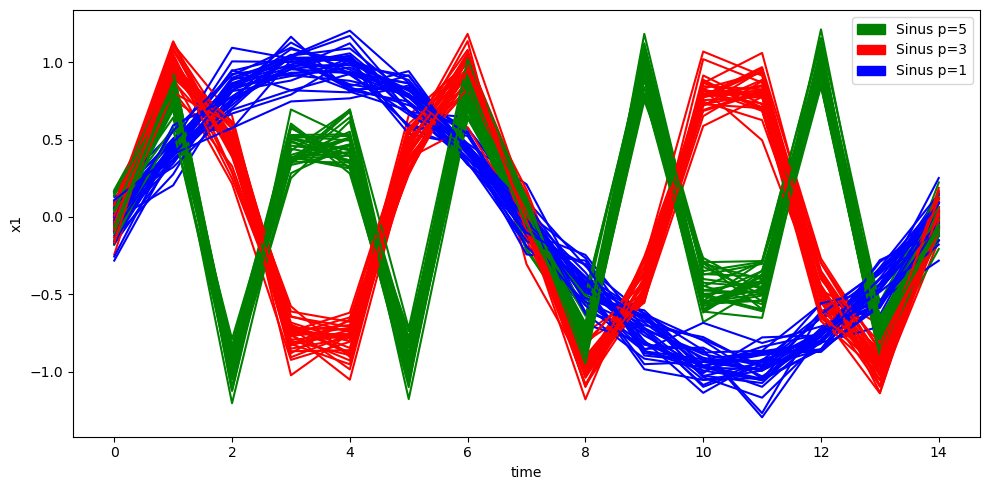

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

colors = {
    "sin1": "blue",
    "sin3": "red",
    "sin5": "green",
}

plt.figure(figsize=(10, 5))
for i, series in enumerate(data):
    plt.plot(series, color=colors[labels[i]])

plt.xlabel("time")
plt.ylabel("x1")
red_patch = mpatches.Patch(color="red", label="Sinus p=3")
green_patch = mpatches.Patch(color="green", label="Sinus p=5")
blue_patch = mpatches.Patch(color="blue", label="Sinus p=1")

plt.legend(handles=[green_patch, red_patch, blue_patch])
plt.tight_layout()
plt.show()

In [5]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
labels = le.fit_transform(labels)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [6]:
import torch

from torch_mas.batch.trainer import BaseTrainer
from torch_mas.batch.internal_model import NClass
from torch_mas.batch.activation_function import BaseActivation
from torch_mas.batch.trainer.learning_rules import (
    IfActivated,
    IfNoActivated,
    IfNoActivatedAndNoNeighbors,
    SimpleDestroy,
)
from torch_mas.data import DataBuffer
from sklearn.metrics import accuracy_score

_, seq_len, input_dim = X_train.shape


internal_nodel = NClass(
    input_dim=input_dim,
    output_dim=1,
    memory_length=input_dim + 1,
)

activation = BaseActivation(
    seq_len=seq_len,
    input_dim=input_dim,
    output_dim=1,
    alpha=0.3,
    neighbor_rate=0.8,
)

trainer = BaseTrainer(
    activation=activation,
    internal_model=internal_nodel,
    R=[0.5],
    bad_th=0.3,
    n_epochs=5,
    learning_rules=[
        IfNoActivatedAndNoNeighbors(),
        IfNoActivated(),
        IfActivated(),
        SimpleDestroy(20000),
    ],
    batch_size=8,
)

dataset = DataBuffer(X_train, y_train)

n_samples = len(dataset)
for e in range(trainer.n_epochs):

    n_agents = trainer.n_agents
    indices = torch.arange(n_samples)
    shuffled_indices = indices[torch.randperm(indices.size(0))]
    batches = shuffled_indices.split(1)
    for batch in batches:
        X, y = dataset[batch]
        trainer.partial_fit(X, y)

    print(f"Epoch {e}, Agents {trainer.n_agents}, {(trainer.n_agents - n_agents):+d}")
    n_agents = trainer.n_agents

Epoch 0, Agents 4, +4
Epoch 1, Agents 4, +0
Epoch 2, Agents 4, +0
Epoch 3, Agents 4, +0
Epoch 4, Agents 4, +0


In [7]:
y_pred = []
for batch in torch.tensor(X_test).split(32):
    y_pred += trainer.predict(batch).tolist()

accuracy_score(y_pred, y_test)

1.0

In [8]:
ts = torch.from_numpy(generate_sin(15, freq=1)).unsqueeze(-1)
ts.shape

torch.Size([15, 1])

## Time points based

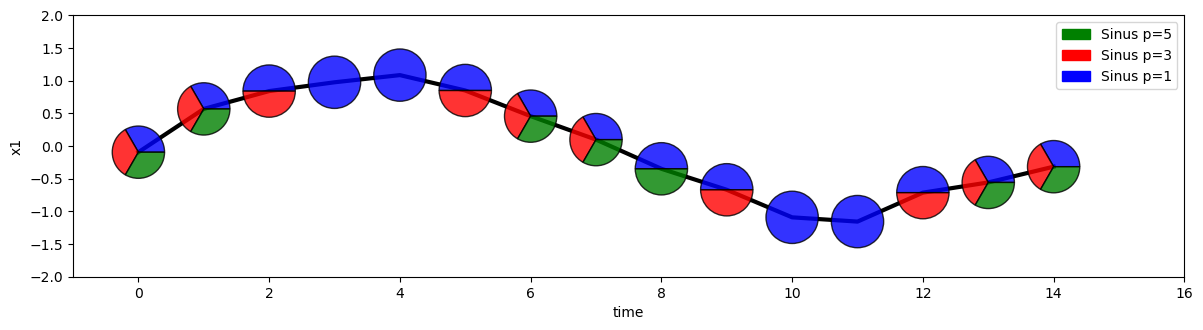

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

agents_mask = torch.ones(trainer.n_agents, dtype=torch.bool)
y_hat = trainer.internal_model(ts.unsqueeze(0), agents_mask).squeeze(-1).transpose(0, 1)
activated_mask, _ = trainer.activation.neighbors(ts.unsqueeze(0), trainer.R)

classes = []
for i, p in enumerate(ts):
    classes.append(y_hat[activated_mask[:, :, i]].tolist())

colors = ["blue", "red", "green"]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(ts, color="black", linewidth=3, zorder=0)

for i, p in enumerate(ts):
    x, y = p.tolist()[0], i
    classe = np.array(classes[i])
    num_colors = np.unique(classe).shape[0]
    angle_step = 360 / num_colors

    for i, c in enumerate(np.unique(classe)):
        color = colors[int(c)]

        wedge = Wedge(
            (y, x),
            0.4,
            i * angle_step,
            (i + 1) * angle_step,
            facecolor=color,
            edgecolor="black",
            alpha=0.8,
        )
        ax.set_aspect("equal", adjustable="box")
        ax.add_patch(wedge)

ax.set_xlim(-1, 16)
ax.set_ylim(-2, 2)
plt.xlabel("time")
plt.ylabel("x1")
red_patch = mpatches.Patch(color="red", label="Sinus p=3")
green_patch = mpatches.Patch(color="green", label="Sinus p=5")
blue_patch = mpatches.Patch(color="blue", label="Sinus p=1")

plt.legend(handles=[green_patch, red_patch, blue_patch])
plt.tight_layout()
plt.show()

## Subsequence based

In [10]:
from torch_mas.common.orthotopes.base import (
    batch_create_temporal_hypercube,
    batch_intersect_temporal_hypercubes,
)


def explain_subsequence(ax, ts, subsequences):
    neighborhood = batch_create_temporal_hypercube(
        ts[:, subsequences], trainer.R.repeat(ts.size(0), 1, 1)
    )

    neighbor_mask = batch_intersect_temporal_hypercubes(
        neighborhood, trainer.activation.orthotopes[:, subsequences]
    )

    neighbor_mask = (
        neighbor_mask.sum(dim=-1)
        > neighbor_mask.shape[-1] * trainer.activation.neighbor_rate
    )

    agents_mask = torch.ones(trainer.n_agents, dtype=torch.bool)
    y_hat = trainer.internal_model(ts, agents_mask).squeeze(-1).transpose(0, 1)

    classes = y_hat[neighbor_mask]
    colors = ["blue", "red", "green"]

    ax.plot(ts.squeeze(0), color="black", linewidth=3, zorder=0)

    # Plotting all points but the last
    if len(subsequences) > 1:
        for i in subsequences[:-1]:
            x, y = float(ts[:, i].squeeze(0)), i

            wedge = Wedge(
                (y, x),
                0.2,
                0,
                360,
                facecolor="black",
                edgecolor="black",
                alpha=0.8,
            )

            ax.add_patch(wedge)

    # Plotting the last point
    x, y = float(ts[:, subsequences[-1]].squeeze(0)), subsequences[-1]
    classe = np.array(classes)
    num_colors = np.unique(classe).shape[0]
    angle_step = 360 / num_colors

    for i, c in enumerate(np.unique(classe)):
        color = colors[int(c)]

        wedge = Wedge(
            (y, x),
            0.4,
            i * angle_step,
            (i + 1) * angle_step,
            facecolor=color,
            edgecolor="black",
            alpha=0.8,
        )
        ax.add_patch(wedge)

    ax.set_aspect("equal", adjustable="box")
    ax.set_xlim(-1, 16)
    ax.set_ylim(-2, 2)

    green_patch = mpatches.Patch(color="green", label="Sinus p=5")
    red_patch = mpatches.Patch(color="red", label="Sinus p=3")
    blue_patch = mpatches.Patch(color="blue", label="Sinus p=1")
    ax.legend(handles=[green_patch, red_patch, blue_patch])

    ax.set_xlabel("time")
    ax.set_ylabel("x1")

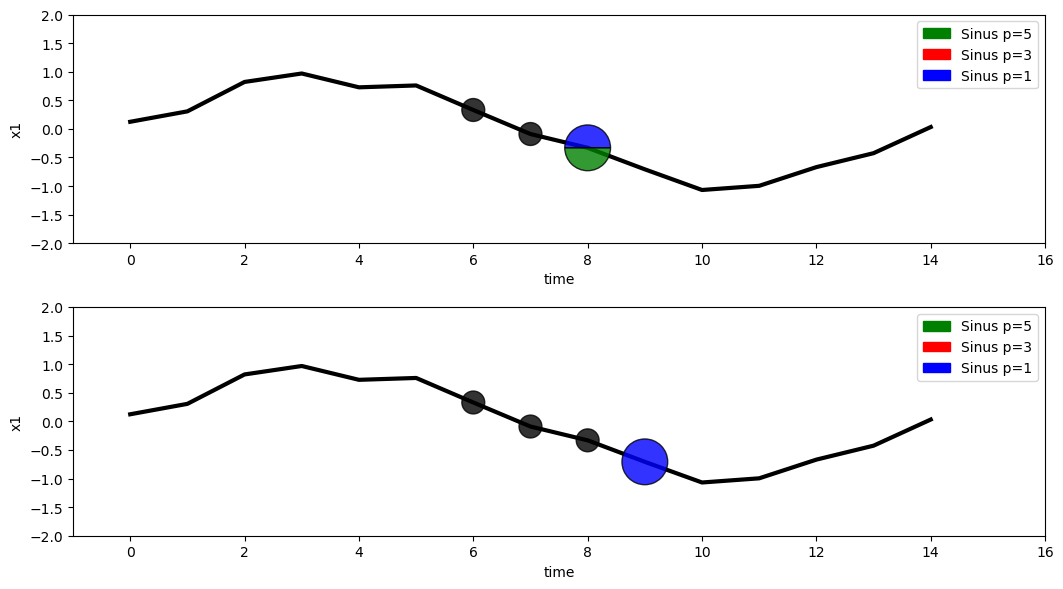

In [11]:
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

ts = torch.from_numpy(generate_sin(15, freq=1)).unsqueeze(-1).unsqueeze(0)

fig, axs = plt.subplots(2, 1, figsize=(14, 6))

##############
# First plot #
##############

subsequences = [6, 7, 8]
explain_subsequence(axs[0], ts, subsequences)

###############
# Second plot #
###############

subsequences = [6, 7, 8, 9]
explain_subsequence(axs[1], ts, subsequences)

plt.tight_layout()
plt.show()

## Instance based

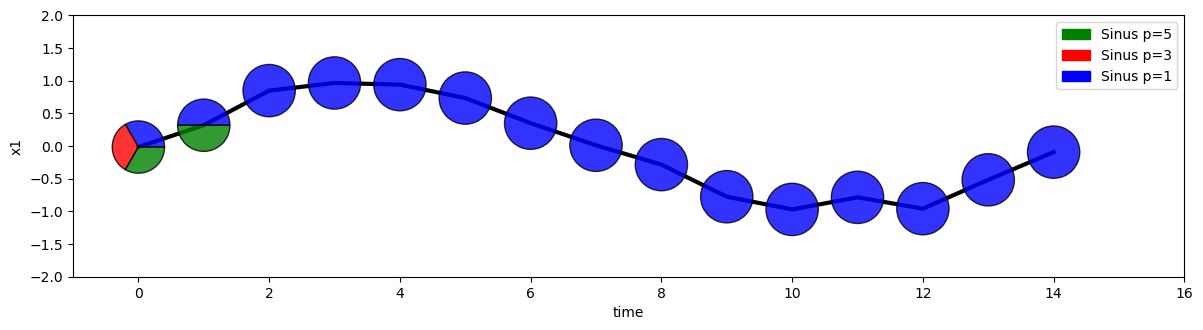

In [12]:
from torch_mas.common.orthotopes.base import (
    batch_create_temporal_hypercube,
    batch_intersect_temporal_hypercubes,
)

import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

ts = torch.from_numpy(generate_sin(15, freq=1)).unsqueeze(-1).unsqueeze(0)


fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(ts.squeeze(0), color="black", linewidth=3, zorder=0)

for xt in range(ts.shape[1]):

    subsequences = [j for j in range(xt + 1)]

    neighborhood = batch_create_temporal_hypercube(
        ts[:, subsequences], trainer.R.repeat(ts.size(0), 1, 1)
    )

    neighbor_mask = batch_intersect_temporal_hypercubes(
        neighborhood, trainer.activation.orthotopes[:, subsequences]
    )

    neighbor_mask = (
        neighbor_mask.sum(dim=-1)
        > neighbor_mask.shape[-1] * trainer.activation.neighbor_rate
    )

    agents_mask = torch.ones(trainer.n_agents, dtype=torch.bool)
    y_hat = trainer.internal_model(ts, agents_mask).squeeze(-1).transpose(0, 1)

    classes = y_hat[neighbor_mask]
    colors = ["blue", "red", "green"]

    # Plotting the last point
    x, y = float(ts[:, subsequences[-1]].squeeze(0)), subsequences[-1]
    classe = np.array(classes)
    num_colors = np.unique(classe).shape[0]
    angle_step = 360 / num_colors

    for i, c in enumerate(np.unique(classe)):
        color = colors[int(c)]

        wedge = Wedge(
            (y, x),
            0.4,
            i * angle_step,
            (i + 1) * angle_step,
            facecolor=color,
            edgecolor="black",
            alpha=0.8,
        )
        ax.add_patch(wedge)

ax.set_aspect("equal", adjustable="box")
ax.set_xlim(-1, 16)
ax.set_ylim(-2, 2)
plt.xlabel("time")
plt.ylabel("x1")
green_patch = mpatches.Patch(color="green", label="Sinus p=5")
red_patch = mpatches.Patch(color="red", label="Sinus p=3")
blue_patch = mpatches.Patch(color="blue", label="Sinus p=1")
ax.legend(handles=[green_patch, red_patch, blue_patch])
plt.tight_layout()
plt.show()